## **Exploratory Data Analysis**

In this notebook we will explore the different datasets and visualize them

Importing Libraries

In [1]:
%%capture
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from pathlib import *
import os
import pickle
import seaborn as sns
import plotly.express as px
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import hvplot.pandas
import holoviews as hv, pandas as pd, colorcet as cc
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os
import datashader
import datashader.transfer_functions
from datashader.utils import lnglat_to_meters
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from datashader.utils import lnglat_to_meters
from bokeh.tile_providers import get_provider, Vendors 
import holoviews.operation.datashader as hd
from datashader.colors import Hot
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9

output_notebook()

### Bokeh Plots

In [ ]:
## Class for viz aos data points -- Bokeh Plots 
class Map_Viz:
    
    # Define general parameters for the Bokeh plot
    Netherlands = x_range, y_range = ((384019.630105,865878.656414), (6577253.409883,7156951.832398))

    plot_width  = int(990)
    plot_height = int(plot_width//1.2)

    
    tile_provider = get_provider(Vendors.CARTODBPOSITRON)
    
    def __init__(self,event_file_name):
        self.event_file_name=event_file_name
        
    def import_data_aos(self):
        """
        Load data from a csv file.
        """
        fields = ['Latitude', 'Longitude']
        complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY", self.event_file_name)
        df=pd.read_csv(complete_path,delimiter=';', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Latitude': float,'Longitude':float},skiprows=range(1,2))
        return df

    # Reusable function to create simple Bokeh plots

    def base_plot(self,tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_kwargs):
        base_plot = figure(tools=tools, plot_width=Map_Viz.plot_width, plot_height=Map_Viz.plot_height,
            x_range=Map_Viz.x_range, y_range=Map_Viz.y_range, outline_line_color=None,
            min_border=0, min_border_left=0, min_border_right=0,
            min_border_top=0, min_border_bottom=0, **plot_kwargs)
        
        base_plot.axis.visible = False
        base_plot.xgrid.grid_line_color = None
        base_plot.ygrid.grid_line_color = None
        
        base_plot.add_tools(BoxZoomTool(match_aspect=True))
        
        return base_plot
    
    def process_data(self):
        df=self.import_data_aos()
        df["Longitude"] = df["Longitude"].astype(float)
        df["Latitude"] = df["Latitude"].astype(float)
        
        df.loc[:, 'Longitude'], df.loc[:, 'Latitude'] = lnglat_to_meters(df.Longitude,df.Latitude)
        
        return df       
    
    def plot_map(self,number_of_data_points):
        df=self.process_data()
        samples = df.sample(n=number_of_data_points)
        p = self.base_plot()
        p.add_tile(Map_Viz.tile_provider)
        options = dict(line_color=None, fill_color='forestgreen', size=5)
        p.circle(x=samples['Longitude'], y=samples['Latitude'], **options)
        show(p)
    
    def plot_map_better(self,number_of_data_points):
        df=self.process_data()
        samples = df.sample(n=number_of_data_points)
        options = dict(line_color=None, fill_color='forestgreen', size=1, alpha=0.1)
        p = self.base_plot()
        p.add_tile(Map_Viz.tile_provider)
        p.circle(x=samples['Longitude'], y=samples['Latitude'], **options)
        show(p)
        



map_viz = Map_Viz("AOS_SUMMARY.csv")

"""Plotting individual events -- uncomment below"""
# map_viz=Map_Viz("brake_warnings.csv") 
# map_viz=Map_Viz("headway_warnings.csv")
# map_viz=Map_Viz("right_left_lane_departure_warning.csv")

# map_viz.plot_map(number_of_data_points=1000000) # overplotting
map_viz.plot_map_better(number_of_data_points=2000000) # no overplotting

In [ ]:
fields = ['Latitude', 'Longitude']
complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY", "right_left_lane_departure_warning.csv")
df=pd.read_csv(complete_path,skipinitialspace=True, usecols=fields, encoding= 'unicode_escape')
df

### Plot all data points

In [ ]:
## Class for viz all data points
"""https://datashader.org/ --> Big data viz library """

class Map_Viz_Datashader:
    plot_width  = int(990)
    plot_height = int(plot_width//1.2)
    Netherlands = x_range, y_range = ((384019.630105,865878.656414), (6577253.409883,7156951.832398))
    def __init__(self,event_file_name):
        self.event_file_name=event_file_name
        
        
    def import_data_td(self):
        """
        Load data from a csv file.
        """

        fields = ['Latitude', 'Longitude']
        complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL", self.event_file_name)
        df=pd.read_csv(complete_path,delimiter=';', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Latitude': float,'Longitude':float},skiprows=range(1,2))
        return df
        
    def import_data_aos(self):
            fields = ['Latitude', 'Longitude']
            complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY", self.event_file_name)
            df=pd.read_csv(complete_path,delimiter=';', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Latitude': float,'Longitude':float},skiprows=range(1,2))
        
            return df
        
    def process_data_aos(self):
        df=self.import_data_aos()
        df["Longitude"] = df["Longitude"].astype(float)
        df["Latitude"] = df["Latitude"].astype(float)
        
        df.loc[:, 'Longitude'], df.loc[:, 'Latitude'] = lnglat_to_meters(df.Longitude,df.Latitude)
        
        return df    
    
    def process_data_td(self):
        df=self.import_data_td()
        df["Longitude"] = df["Longitude"].astype(float)
        df["Latitude"] = df["Latitude"].astype(float)
        
        df.loc[:, 'Longitude'], df.loc[:, 'Latitude'] = lnglat_to_meters(df.Longitude,df.Latitude)
        
        return df    
    

"""Plot Trip Detail - uncomment below"""
# map_viz = Map_Viz_Datashader("TRIP_DETAIL.csv")
# df=map_viz.process_data_td() 

"""Plotting individual events -- uncomment below"""
# map_viz=Map_Viz_Datashader("brake_warnings.csv") 
# map_viz=Map_Viz_Datashader("headway_warnings.csv")
# map_viz=Map_Viz_Datashader("right_left_lane_departure_warning.csv")
map_viz=Map_Viz_Datashader("AOS_SUMMARY.csv")
df=map_viz.process_data_aos() 

plot_width  = int(990)
plot_height = int(plot_width//1.2)
# europe_view=x_range, y_range = ((-1477374.882696,3639625.538827), (4197310.097196,9646964.465816)) # use for plotting trip detail
Netherlands = x_range, y_range = ((384019.630105,865878.656414), (6577253.409883,7156951.832398))

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'Longitude', 'Latitude')
img = tf.shade(agg, cmap="red", how='log')
img

In [ ]:
img = tf.shade(agg, cmap="slateblue", how='log')

In [ ]:
img

In [ ]:
## Save image locally
# bgcolor can be white/black/whatever
from datashader.utils import export_image
export_image(img, "out1", background="black", export_path=".")

In [ ]:
##TODO -> Create functions for repetitive tasks
# ,nrows=20000000,skiprows=range(3, 260000000)
# ,skiprows=range(3, 260000000)
# Input the csv
# Extracting a subset of 1000000 rows by default
def load_data(dir_name,base_filename):
    complete_path=os.path.join(dir_name, base_filename + "." + "csv")
    # df=pd.read_csv(complete_path,sep=';',encoding= 'unicode_escape',nrows=10000,engine='c',infer_datetime_format=True,usecols=['Trip_Summary_Id','Numberplate','Point_time-stamp','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Road_form','Speed_restriction','TNO_Time-stamp'])
    # df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=5000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False,usecols=['Numberplate','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Speed_restriction','TNO_Time-stamp'])))
    
    df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=2000000,low_memory=False)))
    return df

# Dropping the first and last row of csv ("------")
def drop_first_row(df):
    df=df.iloc[1:]
    df=df[:-1]
    return df

def resetIndex(df):
    return df.reset_index()


##TODO -> Rewrite this function

def cast_to_correct_dtype(df):
    
    if 'Id' in df.columns:
        df['Id'] = df['Id'].astype('int')
        
    if 'AOS_position_Id' in df.columns:
        df['AOS_position_Id'] = df['AOS_position_Id'].astype('int')
    
    if 'Acceleration_x' in df.columns:
        df['Acceleration_x'] = df['Acceleration_x'].astype('float')
        
    if 'Acceleration_y' in df.columns:
        df['Acceleration_y'] = df['Acceleration_y'].astype('float')
        
    if 'TNO_Valid' in df.columns:
        df['TNO_Valid'] = df['TNO_Valid'].astype('int')
    
    if 'Latitude' in df.columns:
        df['Latitude'] = df['Latitude'].astype('float')
        
    if 'Longitude' in df.columns:
        df['Longitude'] = df['Longitude'].astype('float')
        
    if 'Event/action_speed' in df.columns:
        df['Event/action_speed'] = df['Event/action_speed'].astype('int')
        
    if 'Event/action_type' in df.columns:
        df['Event/action_type'] = df['Event/action_type'].astype('int')    
        
    if 'Number_of_lanes' in df.columns:
        df['Number_of_lanes'] = df['Number_of_lanes'].astype('int')
        
    if 'Road_class' in df.columns:
        df['Road_class'] = df['Road_class'].astype('int')
        
    if 'Road_type' in df.columns:
        df['Road_type'] = df['Road_type'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id']=df['Crash_position_Id'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id'] = df['Crash_position_Id'].astype('int')
        
    if 'Point_speed' in df.columns:
        df['Point_speed'] = df['Point_speed'].astype('float')
        
    if 'Average_speed_fpp' in df.columns:
        df['Average_speed_fpp'] = df['Average_speed_fpp'].astype('float')  
        
    if 'Average_Speed' in df.columns:
        df['Average_Speed'] = df['Average_Speed'].astype('float')        

    if 'Maximum_speed' in df.columns:
        df['Maximum_speed'] = df['Maximum_speed'].astype('float')     
        
    if 'Meters_travelled' in df.columns:
        df['Meters_travelled'] = df['Meters_travelled'].astype('int')  

    if 'Road_form' in df.columns:
        df['Road_form'] = df['Road_form'].astype('int') 
        
    if 'Speed_restriction' in df.columns:
        df['Speed_restriction'] = df['Speed_restriction'].astype('int') 
        
    if 'Crash_speed' in df.columns:
        df['Crash_speed'] = df['Crash_speed'].astype('int')
        
    if 'Maximum_acceleration' in df.columns:
        df['Maximum_acceleration'] = df['Maximum_acceleration'].astype('float')
        
    if 'Numberplate' in df.columns:
        df['Numberplate']=df['Numberplate'].astype('str')
        

    return df

            

## Handling date time related fields

def cast_date_time(df):
    if 'TNO_Trip-start' in df.columns:
        df['TNO_Trip-start'] = pd.to_datetime(df['TNO_Trip-start'],errors='coerce')
        df['TNO_Trip-start_hour'] = df['TNO_Trip-start'].dt.hour
        
    if 'TNO_Trip-end' in df.columns:
        df['TNO_Trip-end'] = pd.to_datetime(df['TNO_Trip-end'],errors='coerce')
        
    if 'Position_time' in df.columns:
        df['Position_time'] = pd.to_datetime(df['Position_time'],errors='coerce')

    if 'TNO_Time-stamp' in df.columns:
        df['TNO_Time-stamp'] = pd.to_datetime(df['TNO_Time-stamp'],errors='coerce')
        df['TNO_Time-stamp_hour'] = df['TNO_Time-stamp'].dt.hour
        
    if 'Trip_start_time-stamp' in df.columns:
        df['Trip_start_time-stamp'] = pd.to_datetime(df['Trip_start_time-stamp'],errors='coerce')
        df['Trip_start_time-stamp_hour'] = df['Trip_start_time-stamp'].dt.hour
        
    if 'Trip_start_date-stamp' in df.columns:
        df['Trip_start_date-stamp'] = pd.to_datetime(df['Trip_start_date-stamp'],errors='coerce')
        df['Trip_start_date-stamp_hour'] = df['Trip_start_date-stamp'].dt.hour
    return df

## Converting Time Stamps to datetime

def date_and_time_columns(df):
    if 'TNO_Time-stamp' in df.columns:
        df['TNO Trip Date'] = df['TNO_Time-stamp'].dt.date
        df['TNO Trip Time'] = df['TNO_Time-stamp'].dt.time
        df['TNO Trip Hour']=df['TNO_Time-stamp'].dt.hour
        df['TNO Trip Month'] = df['TNO_Time-stamp'].dt.hour
    

    if 'Trip_start_date-stamp' in df.columns:
        df['TNO Trip Date'] = df['Trip_start_date-stamp'].dt.date
        # df['TNO Trip Time'] = df['Trip_start_date-stamp'].dt.time
        # df['TNO Trip Hour']=df['Trip_start_date-stamp'].dt.hour
        df['TNO Trip Month']=df['Trip_start_date-stamp'].dt.month
        
    if 'Trip_start_time-stamp' in df.columns:
        # df['TNO Trip Date'] = df['Trip_start_date-stamp'].dt.date
        df['TNO Trip Time'] = df['Trip_start_time-stamp'].dt.time
        df['TNO Trip Hour']=df['Trip_start_time-stamp'].dt.hour
        # df['TNO Trip Month']=df['Trip_start_date-stamp'].dt.month
        
    return df


def Time_of_the_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x < 12 ):
        return 'Morning'
    elif (x >= 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    
    
def rename_some_stuff(df):
    if 'Event/action_type' in df.columns:
        df["Event type Rename"]=df["Event/action_type"].replace({0: 'Headway Warning = OFF', 1: 'Headway Warning (long)', 2: 'Headway Warning (medium)'
                                                                                 ,3: 'Headway Warning (short)',10:'Lane Departure Warning = OFF',11:'Left Lane Departure Warning = ON'
                                                                                 ,12:'Right Lane Departure Warning = ON',13:'Left and Right Lane Departure Warning = ON'
                                                                                 ,20:' Indicators = OFF',21:'Left Indicator = ON',22:'Right Indicator = ON',23:'Left and Right Indicator = ON'
                                                                                 ,40:'Brakes = OFF',41:'Brakes = ON'})
        
    if 'Road_type' in df.columns:
        df["Road_type_Rename"]=df["Road_type"].replace({0: "Urban", 1: "Motorway",2:"Extra Urban",3:"Unavailable"})
        
    # if 'TNO Trip Month' in df.columns:
    #     df["TNO_Trip_Month_Rename"]=df["TNO Trip Month"].replace({1: "January", 2: "February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})
        
    return df

def detect_overspeeding_count(df):
    # create a list of our conditions
    # if 'Event/action_speed' and 'Speed_restriction' in df.columns:
    #     conditions = [(df['Event/action_speed']> df['Speed_restriction'])]
    #     # # create a list of the values we want to assign for each condition
    #     values = [1]
    #     # create a new column and use np.select to assign values to it using our lists as arguments
    #     df['Overspeeding_event'] = np.select(conditions, values)
        
    # return df

    if 'Point_speed' and 'Speed_restriction' in df.columns:
        conditions = [(df['Point_speed']> df['Speed_restriction'])]
        # # create a list of the values we want to assign for each condition
        values = [1]
        # create a new column and use np.select to assign values to it using our lists as arguments
        df['Overspeeding_event'] = np.select(conditions, values)
        
    return df

def some_processing(df):
    if 'Meters_travelled' in df.columns:
        df['KmTravelled']=df['Meters_travelled']/1000
    return df

In [ ]:
df_TRIP_SUMMARY = (load_data(r"D:\AOS FOT\Octo\CSV Export\TRIP_SUMMARY","TRIP_SUMMARY")
                                      .pipe(drop_first_row)
                                      .pipe(resetIndex)
                                      .pipe(cast_to_correct_dtype)
                                      .pipe(cast_date_time)
                                      .pipe(date_and_time_columns)
                                      .pipe(rename_some_stuff))
df_TRIP_SUMMARY['Part of Day'] = df_TRIP_SUMMARY['TNO Trip Hour'].apply(Time_of_the_day)
df_TRIP_SUMMARY['Count']=1
# df_TRIP_SUMMARY

In [ ]:
df_TRIP_SUMMARY = (load_data(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL","TRIP_DETAIL")
                                      .pipe(drop_first_row)
                                      .pipe(resetIndex)
                                      .pipe(cast_to_correct_dtype)
                                      .pipe(cast_date_time)
                                      .pipe(date_and_time_columns)
                                      .pipe(rename_some_stuff))
df_TRIP_SUMMARY['Part of Day'] = df_TRIP_SUMMARY['TNO Trip Hour'].apply(Time_of_the_day)
df_TRIP_SUMMARY['Count']=1
df_TRIP_SUMMARY

In [ ]:
month_grp = df_TRIP_SUMMARY.groupby("Trip_start_date-stamp")["Meters_travelled"].sum()
month_grp=month_grp.to_frame()
month_grp=month_grp.reset_index()
month_grp['km_travelled']=month_grp['Meters_travelled']/1000
month_grp

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

# Load a numpy structured array from yahoo csv data with fields date, open,
# close, volume, adj_close from the mpl-data/example directory.  This array
# stores the date as an np.datetime64 with a day unit ('D') in the 'date'
# column.
data = month_grp

fig, axs = plt.subplots(3, 1, figsize=(6.4, 7), constrained_layout=True)
# common to all three:
for ax in axs:
    ax.plot('Trip_start_date-stamp', 'Meters_travelled', data=data)
    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)
    ax.set_ylabel(r'Meters Travelled (m)')

# different formats:
ax = axs[0]
ax.set_title('DefaultFormatter', loc='left', y=0.85, x=0.02, fontsize='medium')

ax = axs[1]
ax.set_title('ConciseFormatter', loc='left', y=0.85, x=0.02, fontsize='medium')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax = axs[2]
ax.set_title('Manual DateFormatter', loc='left', y=0.85, x=0.02,
             fontsize='medium')
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [ ]:
px.line(month_grp, x = month_grp["Trip_start_date-stamp"], y = month_grp["Meters_travelled"]/1000,title="Total distance covered (Meters) over time",template="seaborn").update_layout(
    xaxis_title="Date", yaxis_title="Distance Travelled (Meters)"
)

In [ ]:
merge_grp = df_TRIP_SUMMARY.groupby(["TNO Trip Month", "TNO Trip Hour"])["Meters_travelled"].sum()
merge_grp=merge_grp.to_frame()
merge_grp=merge_grp.reset_index()
# merge_grp
# month_grp['km_travelled']=month_grp['Meters_travelled']/1000
# month_grp

In [ ]:
merge_grp["TNO_Trip_Month_Rename"]=merge_grp["TNO Trip Month"].replace({1: "January", 2: "February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

In [ ]:
sns.lineplot(x=merge_grp['TNO Trip Hour'],y=merge_grp['Meters_travelled'],hue=merge_grp["TNO_Trip_Month_Rename"])

In [ ]:
df1_TD=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data\df20M.csv")

In [ ]:
df1_TD['Month'] = pd.DatetimeIndex(df1_TD['TNO_Time-stamp']).month
df1_TD

In [ ]:
merge_grp = df1_TD.groupby(["Month", "TNO Trip Hour"])["Meters_travelled"].sum()
merge_grp=merge_grp.to_frame()
merge_grp=merge_grp.reset_index()
merge_grp

In [ ]:
merge_grp.to_csv("D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\month_hour\month_hour_td40M.csv")

In [ ]:
merge_grp = df1_TD.groupby("Month")["Meters_travelled"].sum()
merge_grp=merge_grp.to_frame()
merge_grp=merge_grp.reset_index()
merge_grp

In [ ]:
merge_grp.to_csv("D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\month\month40M.csv")

In [ ]:
merge_grp = df1_TD.groupby("TNO Trip Hour")["Meters_travelled"].sum()
merge_grp=merge_grp.to_frame()
merge_grp=merge_grp.reset_index()
merge_grp

In [ ]:
merge_grp.to_csv("D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\hour\hour40M.csv")

In [ ]:
merge_grp = df1_TD.groupby("TNO Trip Hour")["Point_speed"].mean()
merge_grp=merge_grp.to_frame()
merge_grp=merge_grp.reset_index()
merge_grp

In [ ]:
merge_grp.to_csv("D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\hour\hour_pointspeed40M.csv")

In [ ]:
sns.lineplot(x=merge_grp['TNO Trip Hour'],y=merge_grp['Meters_travelled'],hue=merge_grp["Month"])

In [ ]:
df1_TD.columns

In [ ]:
def import_process_monthly_data(file_name,rename_column):
    """
    Load data from a csv file.
    """
    complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\month",file_name)
    df=pd.read_csv(complete_path)
    df.drop(['Unnamed: 0'], axis = 1, inplace = True)
    df.rename(columns={'Meters_travelled':rename_column},inplace=True, errors='raise')
    return df

month20M=import_process_monthly_data("month20M.csv",'Meters_travelled20M')
month40M=import_process_monthly_data("month40M.csv",'Meters_travelled40M')
month60M=import_process_monthly_data("month60M.csv",'Meters_travelled60M')
month80M=import_process_monthly_data("month80M.csv",'Meters_travelled80M')
month100M=import_process_monthly_data("month100M.csv",'Meters_travelled100M')
month120M=import_process_monthly_data("month120M.csv",'Meters_travelled120M')
month140M=import_process_monthly_data("month140M.csv",'Meters_travelled140M')
month160M=import_process_monthly_data("month160M.csv",'Meters_travelled160M')
month180M=import_process_monthly_data("month180M.csv",'Meters_travelled180M')
month200M=import_process_monthly_data("month200M.csv",'Meters_travelled200M')
month220M=import_process_monthly_data("month220M.csv",'Meters_travelled220M')
month240M=import_process_monthly_data("month240M.csv",'Meters_travelled240M')
month260M=import_process_monthly_data("month260M.csv",'Meters_travelled260M')
month280M=import_process_monthly_data("month280M.csv",'Meters_travelled280M')

In [ ]:
import pandas as pd
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
# compile the list of dataframes you want to merge
data_frames = [month20M, month40M, month60M,month80M,month100M,month120M,month140M,month160M,month180M,month200M,month220M,month240M,month260M,month280M]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Month'],how='outer'), data_frames).fillna(0)
# df["TNO_Trip_Month_Rename"]=df["TNO Trip Month"].replace({1: "January", 2: "February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

In [ ]:
df_merged=df_merged.sort_values(by=['Month'],ascending=True)
list_of_my_columns = ['Meters_travelled20M', 'Meters_travelled40M', 'Meters_travelled60M','Meters_travelled80M','Meters_travelled100M','Meters_travelled120M','Meters_travelled140M','Meters_travelled160M','Meters_travelled180M','Meters_travelled200M','Meters_travelled220M','Meters_travelled240M','Meters_travelled260M','Meters_travelled280M']
df_merged['total_distance'] = df_merged[list_of_my_columns].sum(axis=1)
df_merged["TNO_Trip_Month_Rename"]=df_merged["Month"].replace({1: "January", 2: "February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})
df_merged

In [ ]:
Total = df_merged['total_distance'].sum()
print(Total/1000)

In [ ]:
sns.lineplot(x=df_merged["TNO_Trip_Month_Rename"],y=df_merged["total_distance"],linewidth=2.5, color='red')
plt.xticks(rotation=50)
plt.xlabel("Month")
plt.ylabel("Distance Covered (m)")

#### **Mean Speed - Days**

TODO 

add function explaining how these files were created

In [ ]:
# def import_process_monthly_data(file_name):
#     """
#     Load data from a csv file.
#     """
#     complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data",file_name)
#     df=pd.read_csv(complete_path)
#     df_urban= df.loc[df['Road_type']==0] #Urban
#     df_motorway= df.loc[df['Road_type']==1] #Motorway
#     df_extra_urban= df.loc[df['Road_type']==2] #Extra Urban
    
#     merge_grp_urban = df_urban.groupby(["TNO Trip Hour","weekday"]).sum()
#     merge_grp_urban=merge_grp_urban.reset_index()
#     merge_grp_urban["weekday"]=merge_grp_urban["weekday"].replace({0: "Monday", 1: "Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
    
#     merge_grp_motorway = df_motorway.groupby(["Month"]).sum()
#     merge_grp_motorway=merge_grp_motorway.reset_index()
#     merge_grp_motorway["weekday"]=merge_grp_motorway["weekday"].replace({0: "Monday", 1: "Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
        
#     merge_grp_extra_urban = df_extra_urban.groupby(["Month"]).sum()
#     merge_grp_extra_urban=merge_grp_extra_urban.reset_index()
#     merge_grp_extra_urban["weekday"]=merge_grp_extra_urban["weekday"].replace({0: "Monday", 1: "Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
    
#     return merge_grp_urban,merge_grp_motorway,merge_grp_extra_urban

# merge_grp_urban,merge_grp_motorway,merge_grp_extra_urban=import_process_monthly_data("df20M.csv")
# merge_grp_urban


In [ ]:
#### Import file
merge_grp=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\Point Speed\motorway\Point_Speed_hour_weekday1_motorway.csv")
merge_grp

In [ ]:
ax=sns.lineplot(x=merge_grp["TNO Trip Hour"],y=merge_grp["Point_Speed_motorway"],hue=merge_grp["weekday"],linewidth=3.5,palette="plasma")
plt.xlabel("Hour of the day",fontsize=15)
plt.ylabel("Mean Point Speed (km/h)",fontsize=15)
ax.legend(title="Day",fontsize=10)
ax.legend(bbox_to_anchor=(1.30, 1), loc='upper right', borderaxespad=0.,title="Day")
plt.title("Road Type - Motorway",fontsize=15)
# plt.xlim(-0.5, 23.5)
# plt.ylim(60,80)
plt.yticks([50,55,60,65,70,75,80,85,90])


In [ ]:
point_speed_3_roads=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\Point Speed\point_Speed_3_roads.csv")
point_speed_3_roads=point_speed_3_roads.rename(columns={'Unnamed: 0':"Day"}, errors='raise')

In [ ]:
point_speed_3_roads

#### Heatmap Point Speed

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[77.22471574,77.00576039,77.04276253,76.66354794,74.73674937,70.26279195,64.99583406,64.11780805,67.32261922,67.4417012,67.92093776,68.50080438,68.20613442,68.54404583,68.01214693,67.30968616,68.29744322,71.67173326,74.74030784,76.04037086,76.94580085,77.46864638,77.6337138	,77.54019212],
         [77.58487678,77.12636287,77.35606058,76.62639839,74.97134469,70.71204615,64.65517226,62.37591014,65.13490569,66.24463835,66.81356514,67.35355036,67.28952508,67.79335749,67.14422461,65.73402689,66.10111251,70.44871094,73.99677083,75.7210203,76.98769201,77.28153685,77.79414812,77.66129885],
         [77.71227616,77.32505013,77.11338543,76.52528385,75.07151652,71.51354144,66.39985513,64.19732536,65.98183477,66.70262755,67.12801674,67.64410009,67.65705701,67.78497747,67.14781776,65.49176472,66.40422316,70.69216089,74.23322216,76.22591126,77.0432851,77.22845356,77.53349755,77.63168969],
         [77.41244795,77.32615656,77.12885478,76.77565419,74.99209271,71.11471833,65.25202936,62.85999191,64.97971213,66.59077725,66.93169665,67.66745195,67.58621413,67.37432462,66.3065311,64.91929278,65.46313308,69.24527448,73.50462848,75.06979324,76.5818323,77.20799775,78.04440063,77.64564254],
         [77.85786061,77.63882374,77.10733693,76.4463634,75.26956079,72.66602215,68.72508737,66.24742181,66.79307725,66.56816482,66.32152526,66.42297562,66.32069838,65.64733442,65.28090003,65.61329746,67.49609688,70.64440015,73.2811676,74.913803,76.2048574,77.04932829,76.94008507,77.06635231],
         [77.68160878,76.94236289,74.29844095,74.74768892,75.17134319,73.88660436,72.89003509,71.74867695,71.67956774,70.83777232,71.251072,71.52631129,71.35013599,71.77554966,71.66986874,71.91587171,72.87131457,74.29727998,74.58549105,75.55970443,75.74164292,77.71788856,77.62651907,75.93864547],
         [78.16621971,78.12108976,77.27216559,77.08828218,77.21876289,76.27232365,73.85003252,72.44362085,72.08952198,72.50421241,72.86943397,72.12960513,72.09311982,71.60853231,71.43704883,72.81159132,74.92322085,77.11530333,76.84421714,78.12607556,77.90170889,78.06509106,77.69170247,78.1283126]]

index=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
columns=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]
# labels = ["Eindhoven","Rotterdam","Amsterdam","Utrecht","Zwolle"]
df_cm = pd.DataFrame(array, index = index,
                  columns = columns)

# matrix = np.triu(df_cm)

plt.figure(figsize = (10,7))
# plt.title('')
sn.heatmap(df_cm, annot=False,fmt=".1f", 
           linewidths=0.5, cmap="coolwarm",cbar_kws={'label': 'Mean Point Speed (km/h)'})
plt.xlabel('Hour of the day',fontsize=15)
plt.ylabel('Day of the week',fontsize=15)
plt.title(r"Heatmap depicting change in mean point speed (km/h)"+"\n"+r"(over different days and hours) - All road types",fontsize=15)

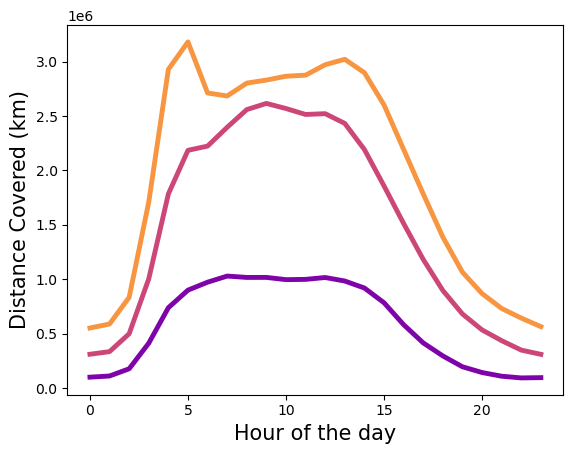

In [4]:
distance_travelled=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\sum_hour\total_sum_hour_road_type.csv")
g=sns.lineplot(x=distance_travelled["TNO Trip Hour"],y=distance_travelled["km_sum"],hue=distance_travelled['road_type'],linewidth=3.5,palette="plasma")
plt.xlabel("Hour of the day",fontsize=15)
plt.ylabel("Distance Covered (km)",fontsize=15)
g.get_legend().remove()
# ax.legend(title="Road Type")
# ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.,title="Road Type",fontsize=10)
# plt.title("Road Type - Urban")
# plt.xlim(-0.5, 23.5)
# plt.ylim(60,80)
# plt.yticks([50,55,60,65,70,75,80,85,90])

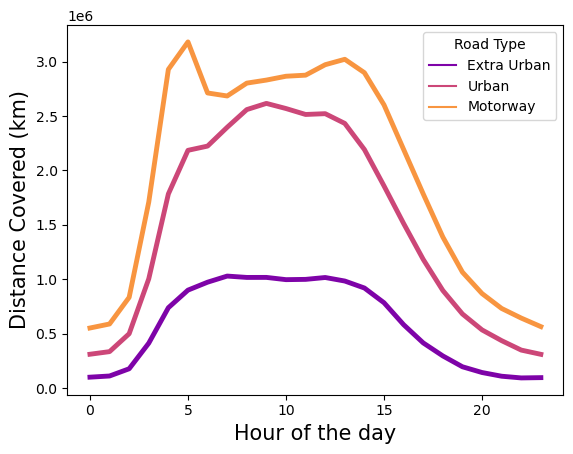

In [5]:
ax=sns.lineplot(x=distance_travelled["TNO Trip Hour"],y=distance_travelled["km_sum"],hue=distance_travelled['road_type'],linewidth=3.5,palette="plasma")
plt.xlabel("Hour of the day",fontsize=15)
plt.ylabel("Distance Covered (km)",fontsize=15)
ax.legend(title="Road Type")

In [ ]:
ax=sns.barplot(x=distance_travelled["TNO Trip Hour"],y=distance_travelled["km_sum"],hue=distance_travelled['road_type'],linewidth=3.5,palette="plasma")
plt.xlabel("Hour of the day")
plt.ylabel("Distance Covered (kilometers)")

#### AOS events plot

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

df = dd.read_csv(r'D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\AOS_SUMMARY.csv',delimiter=';', encoding='unicode_escape',usecols=["Latitude","Longitude"])

# headway_warning=[11,12,13]
# df = df[df['Event/action_type'].isin(headway_warning)]
# df = df[df['Road_type']==0]
with ProgressBar():
    df = df.compute()
    
# df['platedate'] = df['Numberplate'] + df['TNO_Time-stamp'].str[:10]

In [ ]:
df.to_csv(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\AOS_warnings_all.csv")

In [ ]:
len(df)

In [ ]:
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

In [ ]:
df=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\headway_warnings.csv")

In [ ]:
len(df)

In [ ]:
df_hour=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\Overview\Point Speed\point_Speed_3_roads.csv")
df_hour

In [ ]:
corr_matrix = df_hour.corr('pearson') #kind of correlation->  ‘pearson’, ‘kendall’, ‘spearman’
corr_matrix

In [ ]:
corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
corr_matrix = df.corr('pearson') #kind of correlation->  ‘pearson’, ‘kendall’, ‘spearman’
corr_matrix

In [ ]:
corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
df_td = dd.read_csv(r'D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\TRIP_DETAIL.csv',delimiter=';', encoding='unicode_escape', usecols=['TNO_Time-stamp','Point_speed'])
df_td

In [ ]:
fields = ['Point_speed']
df = pd.read_csv(r'D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\TRIP_DETAIL.csv',delimiter=';', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Point_speed': float},skiprows=range(1,2),nrows=10000000)

In [ ]:
fields = ['Speed_restriction']
df = pd.read_csv(r'D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\TRIP_DETAIL.csv',delimiter=';', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Speed_restriction': float},skiprows=range(1,2),nrows=55000000)

In [ ]:
fields = ['Point_speed','Average_speed_fpp','Road_type_Rename']
df = pd.read_csv(r'D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data\df20M.csv', skipinitialspace=True, usecols=fields, encoding= 'unicode_escape',dtype={'Point_speed': float,'Average_speed_fpp':float,'Road_type_Rename':str},skiprows=range(1,2))

In [ ]:
df = df.drop(df[df['Average_speed_fpp']==0].index)
df = df.drop(df[df['Point_speed']==0].index)
df = df.drop(df[df['Point_speed']<20].index)
df = df.drop(df[df['Point_speed']>140].index)


df = df.drop(df[df['Road_type_Rename']=="Unavailable"].index)
df = df.drop(df[df['Road_type_Rename']=="-2"].index)
# df = df.drop(df[df['Road_type_Rename']>120].index)

In [ ]:
df['Road_type_Rename'].unique()

In [ ]:
sns.kdeplot(data=df, x="Point_speed",palette="crest",linewidth=2)
plt.xlabel("Point Speed (km/h)")
plt.title("Distribution of Point Speed")

In [ ]:
# df=cwReturnVehiclePositions_4750[cwReturnVehiclePositions_4750['ReceivedTime_Sep']=='2008-08-08']
import joypy
from matplotlib import cm

joypy.joyplot(df, column=['Point_speed'], by="Road_type_Rename", ylim='own',linecolor="blue", colormap=cm.autumn_r,title="Distribution of Point Speed on different road types")

In [ ]:
joypy.joyplot(df,column=['Point_speed'], by="Road_type_Rename", ylim='own',fill=False, colormap=cm.coolwarm,title="Distribution of Point Speed on different road types",linewidth=2.5)


In [ ]:
joypy.joyplot(df,column=['Point_speed'], by="Road_type_Rename", ylim='own',fill=False, colormap=cm.CMRmap,title="Distribution of Point Speed on different road types",linewidth=2.5)

In [ ]:
joypy.joyplot(df,column=['Point_speed'], by="Road_type_Rename", ylim='own',fill=False, colormap=cm.PuRd,title="Distribution of Point Speed on different road types",linewidth=2.5)

In [ ]:
# df=cwReturnVehiclePositions_4750[cwReturnVehiclePositions_4750['ReceivedTime_Sep']=='2008-08-08']
import joypy
from matplotlib import cm

joypy.joyplot(df, column=['Point_speed'], by="Road_type_Rename", ylim='own',linecolor="blue", colormap=cm.PuRd,title="Distribution of Point Speed on different road types")

### **Saving Hourly Data**
#### **Trip Detail**

- Run the following function for every hour and from `df20M.csv`, `df40M.csv`...`df280M.csv`

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

def save_hourly_data(hour_value,file_name_td,file_name_save_folder,file_name_save):
    complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data",file_name_td)
    df = dd.read_csv(complete_path, encoding='unicode_escape',assume_missing=True,usecols=["Point_speed","Numberplate","TNO_Time-stamp","TNO_Time-stamp_hour"])
    
    df = df[df['TNO_Time-stamp_hour']==hour_value]
    with ProgressBar():
        df = df.compute()
        
    complete_path_save=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data\Hour",file_name_save_folder,file_name_save)
    df.to_csv(complete_path_save)
    
save_hourly_data(1,"df20M.csv","Hour1","hour1_TD_20M.csv")
save_hourly_data(1,"df40M.csv","Hour1","hour1_TD_40M.csv")
save_hourly_data(1,"df60M.csv","Hour1","hour1_TD_60M.csv")
save_hourly_data(1,"df80M.csv","Hour1","hour1_TD_80M.csv")
save_hourly_data(1,"df100M.csv","Hour1","hour1_TD_100M.csv")
save_hourly_data(1,"df120M.csv","Hour1","hour1_TD_120M.csv")
save_hourly_data(1,"df140M.csv","Hour1","hour1_TD_140M.csv")
save_hourly_data(1,"df160M.csv","Hour1","hour1_TD_160M.csv")
save_hourly_data(1,"df180M.csv","Hour1","hour1_TD_180M.csv")
save_hourly_data(1,"df200M.csv","Hour1","hour1_TD_200M.csv")
save_hourly_data(1,"df220M.csv","Hour1","hour1_TD_220M.csv")
save_hourly_data(1,"df240M.csv","Hour1","hour1_TD_240M.csv")
save_hourly_data(1,"df260M.csv","Hour1","hour1_TD_260M.csv")
save_hourly_data(1,"df280M.csv","Hour1","hour1_TD_280M.csv")

### **Load Hourly Data**

- #### **Trip Detail**

In [ ]:
import glob
import os

def process_all_data_hour(hour_file_name,hour_value):
    """_summary_

    Args:
        hour_file_name (_type_):Hour0/Hour1 --> saved using save_hourly_data
        hour_value (_type_): value of hour

    Returns:
        _type_: dataframe
    """
    path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data\Hour",hour_file_name)
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_TD_hour = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    df_TD_hour = df_TD_hour.drop(df_TD_hour[df_TD_hour['Point_speed']==0].index)
    df_TD_hour.drop(['Unnamed: 0', 'Numberplate','TNO_Time-stamp','TNO_Time-stamp_hour'], axis = 1, inplace = True) 
    df_TD_hour.rename(columns={'Point_speed':hour_value},
            inplace=True, errors='raise')
    df_TD_hour['Count'] = np.arange(len(df_TD_hour))

    return df_TD_hour

df_TD_hour0=process_all_data_hour("Hour0","0")
df_TD_hour1=process_all_data_hour("Hour1","1")
df_TD_hour2=process_all_data_hour("Hour2","2")
df_TD_hour3=process_all_data_hour("Hour3","3")
df_TD_hour4=process_all_data_hour("Hour4","4")
df_TD_hour5=process_all_data_hour("Hour5","5")
df_TD_hour6=process_all_data_hour("Hour6","6")
df_TD_hour7=process_all_data_hour("Hour7","7")
df_TD_hour8=process_all_data_hour("Hour8","8")
df_TD_hour9=process_all_data_hour("Hour9","9")
df_TD_hour10=process_all_data_hour("Hour10","10")
df_TD_hour11=process_all_data_hour("Hour11","11")
df_TD_hour12=process_all_data_hour("Hour12","12")
df_TD_hour13=process_all_data_hour("Hour13","13")
df_TD_hour14=process_all_data_hour("Hour14","14")
df_TD_hour15=process_all_data_hour("Hour15","15")
df_TD_hour16=process_all_data_hour("Hour16","16")
df_TD_hour17=process_all_data_hour("Hour17","17")
df_TD_hour18=process_all_data_hour("Hour18","18")
df_TD_hour19=process_all_data_hour("Hour19","19")
df_TD_hour20=process_all_data_hour("Hour20","20")
df_TD_hour21=process_all_data_hour("Hour21","21")
df_TD_hour22=process_all_data_hour("Hour22","22")
df_TD_hour23=process_all_data_hour("Hour23","23")

#### **AOS Summary**

- Run the following function for every hour and from `aos_summary_20M.csv`, `aos_summary_40M.csv`...`aos_summary_140M.csv`

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

def save_hourly_data(hour_value,file_name_aos,file_name_save_folder,file_name_save):
    complete_path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data",file_name_aos)
    df = dd.read_csv(complete_path, encoding='unicode_escape',assume_missing=True,usecols=["Point_speed","Numberplate","TNO_Time-stamp","TNO_Time-stamp_hour"])
    
    df = df[df['TNO_Time-stamp_hour']==hour_value]
    with ProgressBar():
        df = df.compute()
        
    complete_path_save=os.path.join(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data\Hour",file_name_save_folder,file_name_save)
    df.to_csv(complete_path_save)
    
save_hourly_data(1,"aos_summary_20M.csv","Hour1","hour0_AOS_20M.csv")
save_hourly_data(1,"aos_summary_40M.csv","Hour1","hour0_AOS_40M.csv")
save_hourly_data(1,"aos_summary_60M.csv","Hour1","hour0_AOS_60M.csv")
save_hourly_data(1,"aos_summary_80M.csv","Hour1","hour0_AOS_80M.csv")
save_hourly_data(1,"aos_summary_100M.csv","Hour1","hour0_AOS_100M.csv")
save_hourly_data(1,"aos_summary_120M.csv","Hour1","hour0_AOS_120M.csv")
save_hourly_data(1,"aos_summary_140M.csv","Hour1","hour0_AOS_140M.csv")

#### Temporal Stability

In [ ]:
import pandas as pd
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [df_TD_hour0, df_TD_hour1, df_TD_hour2,df_TD_hour3,df_TD_hour4,df_TD_hour5,df_TD_hour6,df_TD_hour7,df_TD_hour8,df_TD_hour9,df_TD_hour10,df_TD_hour11,df_TD_hour12,df_TD_hour13,df_TD_hour14,
               df_TD_hour15,df_TD_hour16,df_TD_hour17,df_TD_hour18,df_TD_hour19,df_TD_hour20,df_TD_hour21,df_TD_hour22,df_TD_hour23]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Count'],
                                            how='inner'), data_frames)
df_merged.head()

In [ ]:
import seaborn as sns
# cmap =sns.diverging_palette(145, 300, s=60, as_cmap=True)

# sns.color_palette("viridis", as_cmap=True)

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_merged.corr(), annot=False,fmt=".1f", 
           linewidths=0.5,cbar_kws={'label': 'Correlation Coefficient'},cmap="Spectral_r")
plt.xlabel('Hour of the day',fontsize=13)
plt.ylabel('Hour of the day',fontsize=13)
plt.title(r"Heatmap depicting correlation of Point Speed"+"\n"+r"(hours) - All road types",fontsize=13)

**Numberplate Temporal Stability**

In [ ]:
import glob
import os

def process_all_data_hour_numberplate(hour_file_name,hour_value):
    """_summary_

    Args:
        hour_file_name (_type_):Hour0/Hour1 --> saved using func `def save_hourly_data()`
        hour_value (_type_): value of hour

    Returns:
        _type_: dataframe
    """
    path=os.path.join(r"D:\AOS FOT\Octo\CSV Export\TRIP_DETAIL\split_data\Hour",hour_file_name)
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_TD_hour = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    df_TD_hour = df_TD_hour.drop(df_TD_hour[df_TD_hour['Point_speed']==0].index)
    df_TD_hour = df_TD_hour.groupby(['Numberplate']).mean('Point_speed')
    df_TD_hour.reset_index(inplace=True)
    df_TD_hour.drop(['Unnamed: 0', 'TNO_Time-stamp_hour'], axis = 1, inplace = True) 
    df_TD_hour.rename(columns={'Point_speed': hour_value},inplace=True, errors='raise')
    return df_TD_hour

df_TD_hour0=process_all_data_hour_numberplate("Hour0","0")
df_TD_hour1=process_all_data_hour_numberplate("Hour1","1")
df_TD_hour2=process_all_data_hour_numberplate("Hour2","2")
df_TD_hour3=process_all_data_hour_numberplate("Hour3","3")
df_TD_hour4=process_all_data_hour_numberplate("Hour4","4")
df_TD_hour5=process_all_data_hour_numberplate("Hour5","5")
df_TD_hour6=process_all_data_hour_numberplate("Hour6","6")
df_TD_hour7=process_all_data_hour_numberplate("Hour7","7")
df_TD_hour8=process_all_data_hour_numberplate("Hour8","8")
df_TD_hour9=process_all_data_hour_numberplate("Hour9","9")
df_TD_hour10=process_all_data_hour_numberplate("Hour10","10")
df_TD_hour11=process_all_data_hour_numberplate("Hour11","11")
df_TD_hour12=process_all_data_hour_numberplate("Hour12","12")
df_TD_hour13=process_all_data_hour_numberplate("Hour13","13")
df_TD_hour14=process_all_data_hour_numberplate("Hour14","14")
df_TD_hour15=process_all_data_hour_numberplate("Hour15","15")
df_TD_hour16=process_all_data_hour_numberplate("Hour16","16")
df_TD_hour17=process_all_data_hour_numberplate("Hour17","17")
df_TD_hour18=process_all_data_hour_numberplate("Hour18","18")
df_TD_hour19=process_all_data_hour_numberplate("Hour19","19")
df_TD_hour20=process_all_data_hour_numberplate("Hour20","20")
df_TD_hour21=process_all_data_hour_numberplate("Hour21","21")
df_TD_hour22=process_all_data_hour_numberplate("Hour22","22")
df_TD_hour23=process_all_data_hour_numberplate("Hour23","23")

In [ ]:
import pandas as pd
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [df_TD_hour0, df_TD_hour1, df_TD_hour2,df_TD_hour3,df_TD_hour4,df_TD_hour5,df_TD_hour6,df_TD_hour7,df_TD_hour8,df_TD_hour9,df_TD_hour10,df_TD_hour11,df_TD_hour12,df_TD_hour13,df_TD_hour14,
               df_TD_hour15,df_TD_hour16,df_TD_hour17,df_TD_hour18,df_TD_hour19,df_TD_hour20,df_TD_hour21,df_TD_hour22,df_TD_hour23]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Numberplate'],
                                            how='inner'), data_frames)
df_merged.drop(['Numberplate'], axis = 1, inplace = True) 
df_merged.head()


In [ ]:
df_merged.corr()

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# df_cm = pd.DataFrame(array)

# matrix = np.triu(df_cm)

plt.figure(figsize = (10,7))
# plt.title('')
sn.heatmap(df_merged.corr(), annot=False,fmt=".1f", 
           linewidths=0.5, cmap="coolwarm",cbar_kws={'label': 'Mean Point Speed (km/h)'})
plt.xlabel('Hour of the day',fontweight="bold",fontsize=13)
plt.ylabel('Hour of the day',fontweight="bold",fontsize=13)
plt.title(r"Heatmap - Mean Point Speed "+"\n"+r"(over hours of the day) - All road types",fontsize=13,fontweight="bold")

In [ ]:
df_corr=df_merged.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap

# sns.heatmap(df_merged.corr(), annot=False,fmt=".1f", 
#            linewidths=0.5, cmap="coolwarm",cbar_kws={'label': 'Mean Point Speed (km/h)'})

sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", 
           linewidths=0.5, cmap="coolwarm", square=True,cbar_kws={'label': 'Correlation Coefficient'})
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
plt.xlabel('Hour of the day',fontweight="bold",fontsize=13)
plt.ylabel('Hour of the day',fontweight="bold",fontsize=13)
plt.title(r"Heatmap - Mean Point Speed (km/h) "+"\n"+r"(over hours of the day) - All road types",fontsize=13,fontweight="bold")

#### AOS Summary

In [ ]:
import glob
import os

def count_of_vals(which_hour,hour_val):
    path=r'D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data\Hour'+which_hour
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_aos_summary0 = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    df_aos_summary0=df_aos_summary0.groupby(['Numberplate','Event type Rename']).size().unstack(fill_value=0)
    df_aos_summary0.drop([' Indicators = OFF', 'Brakes = OFF','Headway Warning = OFF','Lane Departure Warning = OFF', 'Left Indicator = ON','Left and Right Indicator = ON',
        'Right Indicator = ON','Headway Warning (long)','Headway Warning (medium)','Left Lane Departure Warning = ON','Brakes = ON','Right Lane Departure Warning = ON'], axis = 1, inplace = True) 
    df_aos_summary0.rename(columns={'Headway Warning (short)': 'L(III)-HW'+hour_val},inplace=True, errors='raise')
    # df_aos_summary0.rename(columns={'Brakes = ON': 'Braking Events'+hour_val,
    #                             'Headway Warning (long)': 'L(I)-HW'+hour_val,
    #                             'Headway Warning (medium)': 'L(I)-HW'+hour_val,
    #                             'Headway Warning (short)': 'L(I)-HW'+hour_val,
    #                             'Left Lane Departure Warning = ON': 'L-LDW'+hour_val,
    #                             'Right Lane Departure Warning = ON': 'R-LDW'+hour_val},inplace=True, errors='raise')
    df_aos_summary0.reset_index(inplace=True)
    # df_aos_summary0.drop(['Event type Rename'],axis=1,inplace=True)
    
    return df_aos_summary0

In [ ]:
df_aos_summary0=count_of_vals('\Hour0','0')
df_aos_summary1=count_of_vals('\Hour1','1')
df_aos_summary2=count_of_vals('\Hour2','2')
df_aos_summary3=count_of_vals('\Hour3','3')
df_aos_summary4=count_of_vals('\Hour4','4')
df_aos_summary5=count_of_vals('\Hour5','5')
df_aos_summary6=count_of_vals('\Hour6','6')
df_aos_summary7=count_of_vals('\Hour7','7')
df_aos_summary8=count_of_vals('\Hour8','8')
df_aos_summary9=count_of_vals('\Hour9','9')
df_aos_summary10=count_of_vals('\Hour10','10')
df_aos_summary11=count_of_vals('\Hour11','11')
df_aos_summary12=count_of_vals('\Hour12','12')
df_aos_summary13=count_of_vals('\Hour13','13')
df_aos_summary14=count_of_vals('\Hour14','14')
df_aos_summary15=count_of_vals('\Hour15','15')
df_aos_summary16=count_of_vals('\Hour16','16')
df_aos_summary17=count_of_vals('\Hour17','17')
df_aos_summary18=count_of_vals('\Hour18','18')
df_aos_summary19=count_of_vals('\Hour19','19')
df_aos_summary20=count_of_vals('\Hour20','20')
df_aos_summary21=count_of_vals('\Hour21','21')
df_aos_summary22=count_of_vals('\Hour22','22')
df_aos_summary23=count_of_vals('\Hour23','23')

In [ ]:
df['Month'] = pd.DatetimeIndex(df['Date']).month

In [ ]:
import pandas as pd
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [df_aos_summary0, df_aos_summary1, df_aos_summary2,df_aos_summary3,df_aos_summary4,df_aos_summary5,df_aos_summary6,df_aos_summary7,df_aos_summary8,df_aos_summary9,df_aos_summary10,df_aos_summary11,df_aos_summary12,df_aos_summary13,df_aos_summary14,
               df_aos_summary15,df_aos_summary16,df_aos_summary17,df_aos_summary18,df_aos_summary19,df_aos_summary20,df_aos_summary21,df_aos_summary22,df_aos_summary23]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Numberplate'],
                                            how='inner'), data_frames)
df_merged

In [ ]:
# df_merged.rename(columns={'Braking Events0': '0',
#                                 'Braking Events1': '1',
#                                 'Braking Events2': '2',
#                                 'Braking Events3': '3',
#                                 'Braking Events4': '4',
#                                 'Braking Events5': '5',
#                                 'Braking Events6': '6',
#                                 'Braking Events7': '7',
#                                 'Braking Events8': '8',
#                                 'Braking Events9': '9',
#                                 'Braking Events10': '10',
#                                 'Braking Events11': '11',
#                                 'Braking Events12': '12',
#                                 'Braking Events13': '13',
#                                 'Braking Events14': '14',
#                                 'Braking Events15': '15',
#                                 'Braking Events16': '16',
#                                 'Braking Events17': '17',
#                                 'Braking Events18': '18',
#                                 'Braking Events19': '19',
#                                 'Braking Events20': '20',
#                                 'Braking Events21': '21',
#                                 'Braking Events22': '22',
#                                 'Braking Events23': '23'},inplace=True, errors='raise')

In [ ]:
# df_merged.rename(columns={'R-LDW0': '0',
#                                 'R-LDW1': '1',
#                                 'R-LDW2': '2',
#                                 'R-LDW3': '3',
#                                 'R-LDW4': '4',
#                                 'R-LDW5': '5',
#                                 'R-LDW6': '6',
#                                 'R-LDW7': '7',
#                                 'R-LDW8': '8',
#                                 'R-LDW9': '9',
#                                 'R-LDW10': '10',
#                                 'R-LDW11': '11',
#                                 'R-LDW12': '12',
#                                 'R-LDW13': '13',
#                                 'R-LDW14': '14',
#                                 'R-LDW15': '15',
#                                 'R-LDW16': '16',
#                                 'R-LDW17': '17',
#                                 'R-LDW18': '18',
#                                 'R-LDW19': '19',
#                                 'R-LDW20': '20',
#                                 'R-LDW21': '21',
#                                 'R-LDW22': '22',
#                                 'R-LDW23': '23'},inplace=True, errors='raise')

In [ ]:
df_merged.rename(columns={'L(III)-HW0': '0',
                                'L(III)-HW1': '1',
                                'L(III)-HW2': '2',
                                'L(III)-HW3': '3',
                                'L(III)-HW4': '4',
                                'L(III)-HW5': '5',
                                'L(III)-HW6': '6',
                                'L(III)-HW7': '7',
                                'L(III)-HW8': '8',
                                'L(III)-HW9': '9',
                                'L(III)-HW10': '10',
                                'L(III)-HW11': '11',
                                'L(III)-HW12': '12',
                                'L(III)-HW13': '13',
                                'L(III)-HW14': '14',
                                'L(III)-HW15': '15',
                                'L(III)-HW16': '16',
                                'L(III)-HW17': '17',
                                'L(III)-HW18': '18',
                                'L(III)-HW19': '19',
                                'L(III)-HW20': '20',
                                'L(III)-HW21': '21',
                                'L(III)-HW22': '22',
                                'L(III)-HW23': '23'},inplace=True, errors='raise')

In [ ]:
df_corr=df_merged.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap

# sns.heatmap(df_merged.corr(), annot=False,fmt=".1f", 
#            linewidths=0.5, cmap="coolwarm",cbar_kws={'label': 'Mean Point Speed (km/h)'})

sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", 
           linewidths=0.5, cmap="coolwarm", square=True,cbar_kws={'label': 'Correlation Coefficient'})
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
plt.xlabel('Hour of the day',fontweight="bold",fontsize=13)
plt.ylabel('Hour of the day',fontweight="bold",fontsize=13)
plt.title(r"Heatmap : L(III)-HW "+"\n"+r"(over hours of the day) - All road types",fontsize=13,fontweight="bold")

AOS Summary count plot

In [ ]:

%%capture
import pandas as pd
# import modin.pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
# import vaex # https://vaex.io/docs/index.html"
import pathlib
from pathlib import *
import os
import pickle
# import cufflinks as cf
# import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

init_notebook_mode(connected=True)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [ ]:
def total_aos_event_count(df):
    df=df.groupby(['Event type Rename','Road_type_Rename']).size().unstack(fill_value=0)
    df.reset_index(inplace=True)
    return df

In [ ]:
df_aos_hour0=total_aos_event_count(df_aos_hour0)
df_aos_hour0

In [ ]:
df_aos_hour0.to_csv(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data\Hour\df_aos_hour23.csv")

In [ ]:
distance_travelled=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data\Hour\Urban\df_aos_hour0.csv")
distance_travelled.columns

In [ ]:
sns.set_palette("pastel")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Brakes = ON"],linewidth=3.5,label="Braking Events")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (long)"],linewidth=3.5,label="HW-L(I)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (medium)"],linewidth=3.5,label="HW-L(II)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (short)"],linewidth=3.5,label="HW-L(III)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Left Lane Departure Warning = ON"],linewidth=3.5,label="L-LDW")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
plt.xlabel("Hour of the day")
plt.ylabel("Number of Data Points")
plt.legend(title="AOS Events")
plt.title("AOS events recorded in Urban areas")

In [ ]:
distance_travelled1=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\AOS_SUMMARY\split_data\Hour\Motorway\df_aos_hour0.csv")
distance_travelled1.columns

In [ ]:
# sns.set_palette("plasma")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Brakes = ON"],linewidth=3.5,label="Braking Events")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (long)"],linewidth=3.5,label="HW-L(I)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (medium)"],linewidth=3.5,label="HW-L(II)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (short)"],linewidth=3.5,label="HW-L(III)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Lane Departure Warning = ON"],linewidth=3.5,label="L-LDW")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
plt.xlabel("Hour of the day")
plt.ylabel("Number of Data Points")
plt.legend(title="AOS Events")
plt.title("AOS events recorded in Urban areas")

In [ ]:
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Left Lane Departure Warning = ON"],linewidth=3.5,label="Urban")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Lane Departure Warning = ON"],linewidth=3.5,label="Motorway")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Lane Departure Warning = ON"],linewidth=3.5,label="Motorway")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Left Lane Departure Warning = ON"],linewidth=3.5,label="Urban")

In [ ]:
distance_travelled.columns

In [ ]:
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Right Indicator = ON"],linewidth=3.5,label="Right Indicator = ON")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded in Urban Areas")
# sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Lane Departure Warning = ON"],linewidth=3.5,label="Motorway")

In [ ]:
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Indicator = ON"],linewidth=3.5,label="Right Indicator = ON")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded on Motorways")

In [ ]:
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Lane Departure Warning = ON"],linewidth=3.5,label="L-LDW")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Indicator = ON"],linewidth=3.5,label="Left Indicator = ON")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded on Motorways")

In [ ]:
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Lane Departure Warning = ON"],linewidth=3.5,label="L-LDW")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Left Indicator = ON"],linewidth=3.5,label="Left Indicator = ON")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Right Indicator = ON"],linewidth=3.5,label="Right Indicator = ON")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded on Motorways")
plt.legend(loc="upper right")

In [ ]:
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Left Lane Departure Warning = ON"],linewidth=3.5,label="L-LDW")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Left Indicator = ON"],linewidth=3.5,label="Left Indicator = ON")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Right Lane Departure Warning = ON"],linewidth=3.5,label="R-LDW")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Right Indicator = ON"],linewidth=3.5,label="Right Indicator = ON")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded in Urban Areas")


In [ ]:
distance_travelled.columns

In [ ]:
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (long)"],linewidth=3.5,label="HW-L(I)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (medium)"],linewidth=3.5,label="HW-L(II)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Headway Warning (short)"],linewidth=3.5,label="HW-L(III)")
sns.lineplot(x=distance_travelled["Hour"],y=distance_travelled["Brakes = ON"],linewidth=3.5,label="Braking Events")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded in Urban Areas")

In [ ]:
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (long)"],linewidth=3.5,label="HW-L(I)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (medium)"],linewidth=3.5,label="HW-L(II)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Headway Warning (short)"],linewidth=3.5,label="HW-L(III)")
sns.lineplot(x=distance_travelled1["Hour"],y=distance_travelled1["Brakes = ON"],linewidth=3.5,label="Braking Events")
plt.ylabel("Number of Data Points")
plt.title("AOS Events recorded on Motorways")